In [418]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import emcee
import corner
%matplotlib widget

### Definition of the Matern 5/2 Kernel and its derivatives

In [35]:
def matern52(t1, t2, *, sigma = 2.3, rho = 1.5):
    x = np.sqrt(5) * np.abs(t1 - t2) / rho
    return sigma ** 2 * (1 + x + x ** 2 / 3) * np.exp(-x)

def matern52_cross(t1, t2, *, sigma = 2.3, rho = 1.5):
    x = np.sqrt(5) * np.abs(t1 - t2) / rho
    return np.sqrt(5) * sigma ** 2 * np.sign(t1 - t2) * (x + x ** 2) / (3 * rho) * np.exp(-x)

def matern52_grad(t1, t2, *, sigma = 2.3, rho = 1.5):
    x = np.sqrt(5) * np.abs(t1 - t2) / rho
    return (5 / 3) * sigma ** 2 * (1 + x - x ** 2) / rho ** 2 * np.exp(-x)

### Definition of the diagonal and off-diagonal terms for the covariance block matrix

In [36]:
def K_FF(t_f, p):
    
    A, B, C, D, sigma, rho = p
    
    first_term = A**2 * matern52(t_f[:, None], t_f[None, :], sigma=sigma, rho=rho)
    #second_term = A*B * matern52_cross(t_f[:, None], t_f[None, :])
    #third_term = B*A * matern52_cross(t_f[:, None], t_f[None, :])
    fourth_term = B**2 * matern52_grad(t_f[:, None], t_f[None, :], sigma=sigma, rho=rho)
    
    return first_term + fourth_term
    
def K_FRV(t_f, t_rv, p):
    
    A, B, C, D, sigma, rho = p
    
    first_term = A*C * matern52(t_f[:, None], t_rv[None, :], sigma=sigma, rho=rho)
    second_term = A*D * matern52_cross(t_f[:, None], t_rv[None, :], sigma=sigma, rho=rho)
    third_term = B*C * matern52_cross(t_rv[None, :], t_f[:, None], sigma=sigma, rho=rho)
    fourth_term = B*D * matern52_grad(t_f[:, None], t_rv[None, :], sigma=sigma, rho=rho)
    
    return first_term + second_term + third_term + fourth_term
    
def K_RVRV(t_rv, p):
    
    A, B, C, D, sigma, rho = p
    
    first_term = C**2 * matern52(t_rv[:, None], t_rv[None, :], sigma=sigma, rho=rho)
    #second_term = C*D * matern52_cross(t_rv[:, None], t_rv[None, :])
    #third_term = D*C * matern52_cross(t_rv[:, None], t_rv[None, :])
    fourth_term = D**2 * matern52_grad(t_rv[:, None], t_rv[None, :], sigma=sigma, rho=rho)
    
    return first_term + fourth_term

### Load in time series data, use only certain sections

In [411]:
var_path = "example data/tau_0.050"

t_flux = np.load(var_path + "_t.npy")[:650]
flux = np.load(var_path + "_f.npy")[:650]
flux_err = np.load(var_path + "_ferr.npy")[:650]
flux -= flux_err

mu = np.mean(flux)
flux = (flux / mu - 1) * 1e3
flux_err = flux_err * 1e3 / mu

t_rad = np.load(var_path + "_t.npy")[450:1000]
rv = np.load(var_path + "_rv.npy")[450:1000]
rv_err = np.load(var_path + "_rverr.npy")[450:1000]

In [412]:
def cov_mat(params, t_f, t_rv):
    """
    function to build covariance matrix
    """
    Kappa11 = K_FF(t_f, params)
    Kappa12 = K_FRV(t_f, t_rv, params)
    Kappa21 = Kappa12.T
    Kappa22 = K_RVRV(t_rv, params)

    cov = np.concatenate((
          np.concatenate((Kappa11, Kappa12), axis=1),
          np.concatenate((Kappa21, Kappa22), axis=1),
          ), axis=0)
    
    return cov

In [415]:
def log_like(r, K):
    """
    Pulled from Dan's notebook, updated with Cholesky decomposition
    https://github.com/dfm/gp/blob/main/solutions.ipynb
    
    The multivariate Gaussian ln-likelihood (up to a constant) for the
    vector ``r`` given a covariance matrix ``K``.
    
    :param r: ``(N,)``   The residual vector with ``N`` points.
    :param K: ``(N, N)`` The square (``N x N``) covariance matrix.
    
    :returns lnlike: ``float`` The Gaussian ln-likelihood. 
    
    """
    # Slow version, factor ~2x slower.
    #return -0.5 * (np.dot(r, np.linalg.solve(K, r)) + np.linalg.slogdet(K)[1])
    
    # Cholesky decomposition, faster
    # For more info, check out: https://math.stackexchange.com/questions/3158303/using-cholesky-decomposition-to-compute-covariance-matrix-determinant
    cho_decomp = scipy.linalg.cho_factor(K)
    log_det_cov = 2*np.sum(np.log(np.diag(cho_decomp[0])))
    return -0.5 * (np.dot(r, scipy.linalg.cho_solve(cho_decomp, r)) + log_det_cov)

In [416]:
def gp_log_prob(params, log_like_fn, t_f, t_rv, y_f, y_rv, y_err):
    """
    add in mean flux and mean RVs as potential parameters in the model
    """
    #Hard uniform bounds for coefficients
    #if params[-1] < 0 or params[-1] > 10:
    #    return -np.inf
    #if params[-2] < 0 or params[-2] > 30:
    #    return -np.inf
    #if params[-3] < -15 or params[-3] > 15:
    #    return -np.inf
    #if np.any(params[:-3] < -5.0) or np.any(params[:-3] > 5.0):
    #    return -np.inf
    
    # Compute the covariance matrix
    K = cov_mat(params, t_f, t_rv)
    K[np.diag_indices_from(K)] += y_err**2
    
    # Compute the log likelihood
    return log_like_fn(np.concatenate((y_f, y_rv)), K)

def gp_neg_log_prob(params, log_like_fn, t_f, t_rv, y_f, y_rv, y_err):
    
    # Compute the covariance matrix
    K = cov_mat(params, t_f, t_rv)
    K[np.diag_indices_from(K)] += y_err**2
    
    # Compute the negative log likelihood
    return -log_like_fn(np.concatenate((y_f, y_rv)), K)

### Sampling Parameters

In [408]:
ndim = 6
nwalkers = 50
pos = np.array([0.05, 0.04, 0.01, 4.5, 20.0, 1.5])
pos = pos + 1e-1*np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, gp_log_prob,
                                args=(log_like, t_flux, t_rad, flux, rv, np.concatenate((flux_err, rv_err))))

In [410]:
##pos, _, _ = sampler.run_mcmc(pos, 500, progress=True)
sampler.reset()
sampler.run_mcmc(pos, 2500, progress=True);

  0%|▏                                       | 8/2500 [00:28<2:33:47,  3.70s/it]Traceback (most recent call last):
  File "/opt/anaconda3/envs/starry/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/pp/slx5z51s7j9d_w8l_mb2blvc0001sl/T/ipykernel_57806/2755192346.py", line 20, in gp_log_prob
    return log_like_fn(np.concatenate((y_f, y_rv)), K)
  File "/var/folders/pp/slx5z51s7j9d_w8l_mb2blvc0001sl/T/ipykernel_57806/4253476244.py", line 17, in log_like
    cho_decomp = scipy.linalg.cho_factor(K)
  File "/opt/anaconda3/envs/starry/lib/python3.8/site-packages/scipy/linalg/decomp_cholesky.py", line 152, in cho_factor
    c, lower = _cholesky(a, lower=lower, overwrite_a=overwrite_a, clean=False,
  File "/opt/anaconda3/envs/starry/lib/python3.8/site-packages/scipy/linalg/decomp_cholesky.py", line 37, in _cholesky
    raise LinAlgError("%d-th leading minor of the array is not positive "
numpy.linalg.LinA

emcee: Exception while calling your likelihood function:
  params: [-0.77263226  0.76053969 -0.12088426  5.69700197 20.18449657 -0.11945261]
  args: (<function log_like at 0x7f89686ce700>, array([ 0.        ,  0.02083333,  0.04166667,  0.0625    ,  0.08333333,
        0.10416667,  0.125     ,  0.14583333,  0.16666667,  0.1875    ,
        0.20833333,  0.22916667,  0.25      ,  0.27083333,  0.29166667,
        0.3125    ,  0.33333333,  0.35416667,  0.375     ,  0.39583333,
        0.41666667,  0.4375    ,  0.45833333,  0.47916667,  0.5       ,
        0.52083333,  0.54166667,  0.5625    ,  0.58333333,  0.60416667,
        0.625     ,  0.64583333,  0.66666667,  0.6875    ,  0.70833333,
        0.72916667,  0.75      ,  0.77083333,  0.79166667,  0.8125    ,
        0.83333333,  0.85416667,  0.875     ,  0.89583333,  0.91666667,
        0.9375    ,  0.95833333,  0.97916667,  1.        ,  1.02083333,
        1.04166667,  1.0625    ,  1.08333333,  1.10416667,  1.125     ,
        1.14583333,

LinAlgError: 3-th leading minor of the array is not positive definite

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

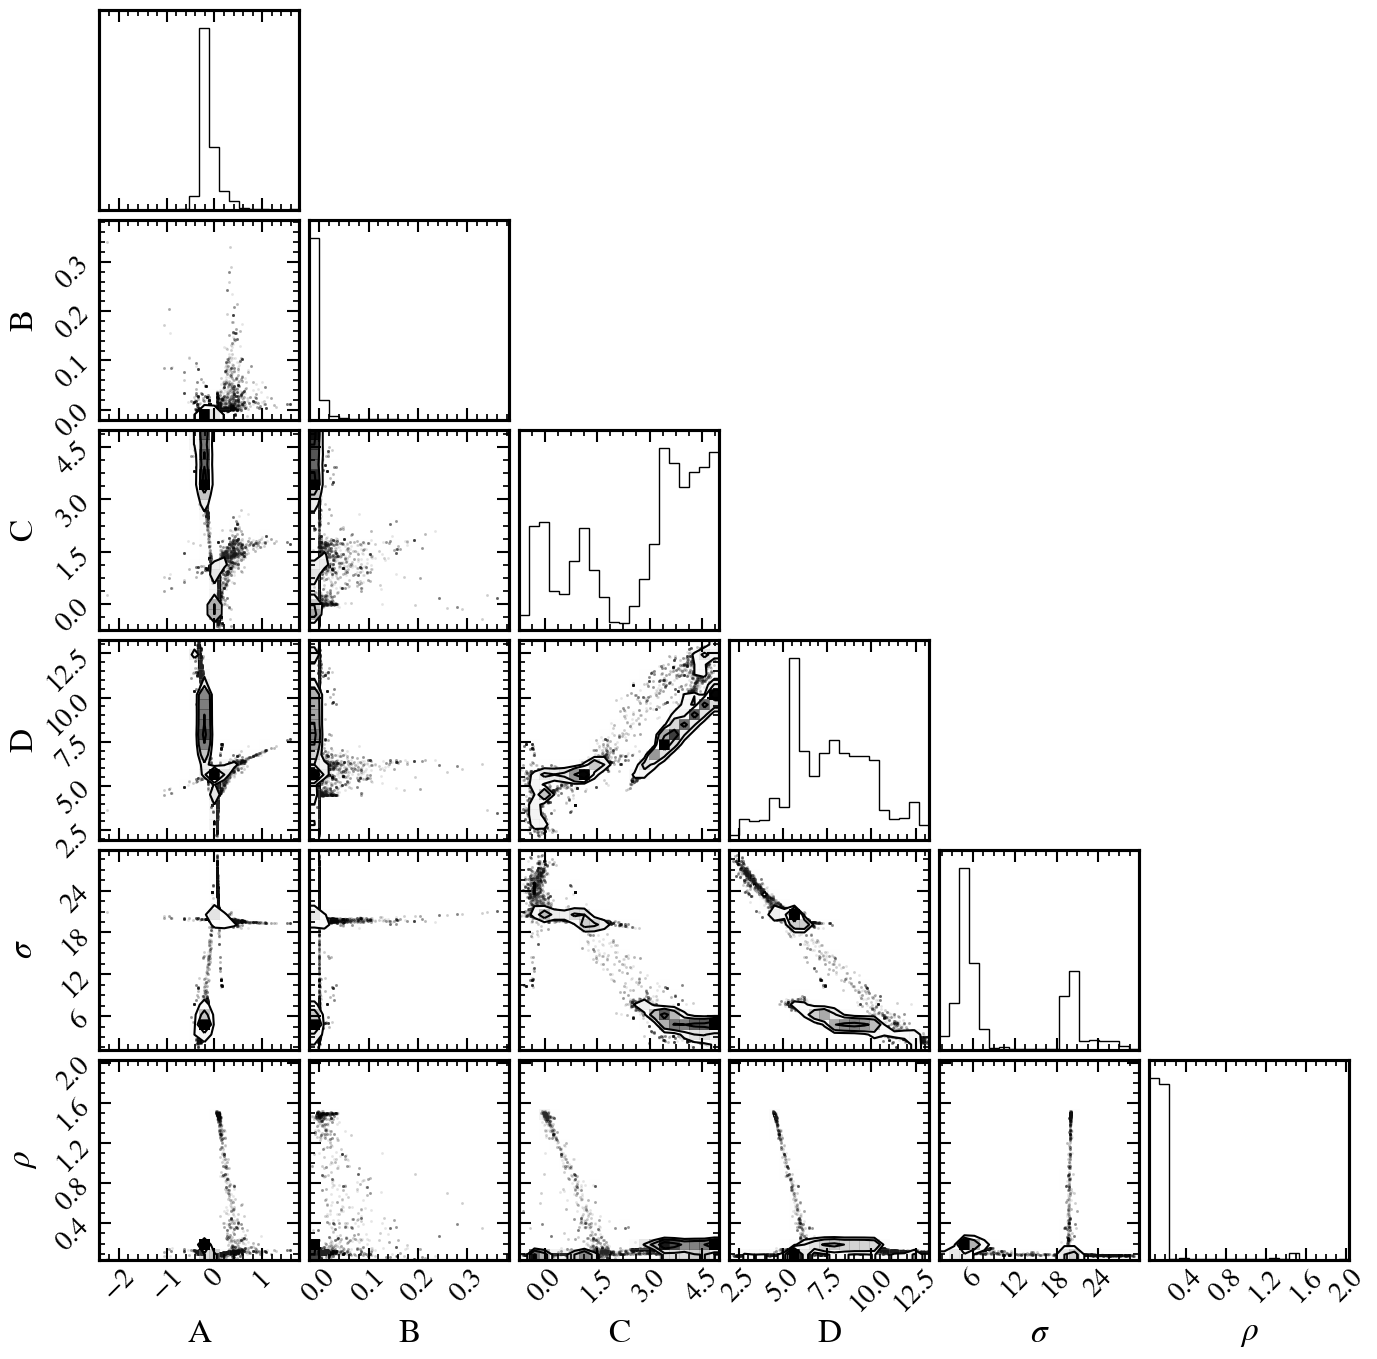

In [272]:
corner.corner(sampler.flatchain[500:], labels=["A", "B", "C", "D", r"$\sigma$", r"$\rho$"])

In [268]:
plt.close()
#np.save("example data/latent_GP_mcmc_samples_v3.npy", sampler.flatchain)

### Optimize model parameters

In [ ]:
def minimize_gp_kernel():
    p0 = np.array([0.1, 0.04, 0.07, 5.0, 20.0, 2.0])
    
    b = [(-2.5, 2.5), (-2.5, 2.5), (-2.5, 2.5), (-25.0, 25.0), (0.5, 50.0), (2.5, 10.0)]
    
    result = scipy.optimize.minimize(gp_neg_log_prob, p0, args=(log_like, t_flux, t_rad, flux, rv))#, bounds=b)

    return result

#res = minimize_gp_kernel()
#print(res)

In [407]:
#print(gp_neg_log_prob(res.x, log_like, t_flux, t_rad, flux, rv))
print(gp_log_prob(np.array([0.1, 0.04, 0.07, 5.0, 20.0, 2.0]), log_like, t_flux, t_rad, flux, rv, np.concatenate((flux_err, rv_err))))
print(gp_log_prob(np.array([0.25, 1.0, 4.0, 2.0, 15.0, 0.25]), log_like, t_flux, t_rad, flux, rv, np.concatenate((flux_err, rv_err))))

-625343.7114507734
-33617.33001542393


In [406]:
def sample_gp(random, K, size=None):
    return random.multivariate_normal(np.zeros(K.shape[0]), K, size=size)

def plot_data_and_model(p0=None):
    
    if p0 is None:
        p0 = res.x
    cov_test = cov_mat(p0, t_flux, t_rad)
    #y = sample_gp(np.random.default_rng(6584), cov_test)
    y = sample_gp(np.random.default_rng(432), cov_test)
    
    fig, ax = plt.subplots(nrows=2, figsize=(12, 6), gridspec_kw={'hspace':0.0})
    
    ax[0].plot(t_flux, flux, lw=2.0, color='blue')
    ax[1].plot(t_rad, rv-rv_err, lw=2.0, color='orange')
    
    ax[0].plot(t_flux, y[:len(t_flux)], lw=2.0, color='black', ls='--')
    ax[1].plot(t_rad, y[len(t_flux):], lw=2.0, color='black', ls='--')
    
    ax[0].set_ylabel(r"Norm. Flux (ppt)")
    ax[1].set_ylabel(r"RV (m s$^{-1}$")
    
    ax[1].set_xlabel(r"Time (day)")
    
    plt.tight_layout()
    plt.show()
    
#plot_data_and_model(p0 = np.array([0.1, 0.04, 0.07, 5.0, 20.0, 2.0]))
plot_data_and_model(p0 = np.array([0.25, 1.0, 4.0, 2.0, 15.0, 0.25]))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …